First, we load in the data.

In [26]:
import json

with open("./data/training_data.json", 'r') as f:
    datastore = json.load(f)

headlines = []
labels = []

for item in datastore:
    headlines.append(item['title'])
    labels.append(item['good_news'])

Augment NLP with Translate


In [27]:
from deep_translator import GoogleTranslator

def back_translate(sequence, language="es"):
    translated = GoogleTranslator(source='auto', target=language).translate(sequence)

    translated_back = GoogleTranslator(source=language, target="en").translate(translated)

    return translated_back

In [36]:
from tqdm.notebook import tqdm
import random

previous_size = len(headlines)

pbar = tqdm(total=len(headlines))
for i in range(len(headlines)):
    if random.randint(0, 1) == 0:
        pbar.update(1)
        continue
    headline = headlines[i]
    label = labels[i]
    new_headline = back_translate(headline)
    if new_headline != headline:
        headlines.append(new_headline)
        labels.append(label)
    pbar.update(1)

print(f"Added {len(headlines) - previous_size} augmented data to create a new training size of {len(headlines)} compared to the previous size of {previous_size}")
pbar.close()

  0%|          | 0/1890 [00:00<?, ?it/s]

Added 859 augmented data to create a new training size of 2749 compared to the previous size of 1890


Download nltk resources

In [ ]:
import nltk
nltk.download ()

Remove stop words and contractions.

In [64]:
def preProcess(sentence):
    words = []
    for word in sentence.split():
        if not word in stopwords.words('english'):
            words.append(stemmer.stem(word).replace("'", ""))

    return ' '.join(words)


In [65]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()
for i in range(len(headlines)):
    headlines[i] = preProcess(headlines[i])




Split the data.

In [66]:
from sklearn.model_selection import train_test_split
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(headlines, labels, train_size=0.75)
print(f"Split into {len(training_headlines)} Training sets and {len(testing_headlines)} Testing sets.")

Split into 2061 Training sets and 688 Testing sets.


In [71]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# training tokenizer
tokenizer.fit_on_texts(headlines)
word_index = tokenizer.word_index
print(f"Word Index Size: {len(word_index)}")

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 4260


Tune Hyperparameters.

In [78]:
embedding_dim = 10
batch_size = 128
epochs = 50
learning_rate = 2e-4

In [79]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

Train model.

In [80]:
history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[])

Epoch 1/50
33/33 [==============================] - 3s 32ms/step - loss: 0.6927 - accuracy: 0.5245 - val_loss: 0.6923 - val_accuracy: 0.5640
Epoch 2/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6917 - accuracy: 0.5381 - val_loss: 0.6904 - val_accuracy: 0.5640
Epoch 3/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6909 - accuracy: 0.5410 - val_loss: 0.6888 - val_accuracy: 0.5640
Epoch 4/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6897 - accuracy: 0.5405 - val_loss: 0.6869 - val_accuracy: 0.5640
Epoch 5/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6879 - accuracy: 0.5405 - val_loss: 0.6851 - val_accuracy: 0.5640
Epoch 6/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6870 - accuracy: 0.5405 - val_loss: 0.6839 - val_accuracy: 0.5640
Epoch 7/50
33/33 [==============================] - 0s 13ms/step - loss: 0.6836 - accuracy: 0.5405 - val_loss: 0.6810 - val_accuracy: 0.5640
Epoch 8/50
33

Plot findings.

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def plot_lr(history):
    lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs, history.history["val_loss"])

    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')

    # Set the plot boundaries
    plt.axis([1e-8, 1e-3, 0, 2])
    plt.show()

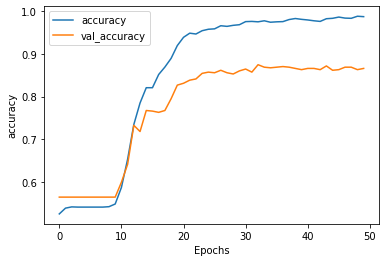

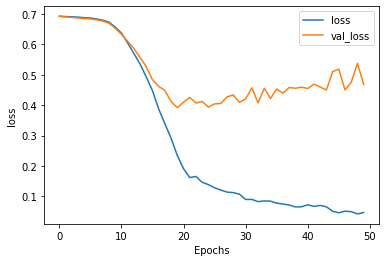

In [81]:
#plot_lr(history)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")